In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
import sys
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from collections import defaultdict


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
PATH = '/content/drive/MyDrive/solar_data'
sys.path.insert(0, PATH)

In [9]:
from GRU_model import GRUNet

In [10]:
WINDOW_SIZE = 25

In [11]:
#TODO make supervised learning dataset from csv files
#TODO build dataloader
solar_data = np.genfromtxt(PATH + '/data/training_data/train_solar.csv', delimiter=',', skip_header=1)
wind_data = np.genfromtxt(PATH + '/data/training_data/train_wind.csv', delimiter=',',skip_header=1)
solar_data_val = np.genfromtxt(PATH + '/data/training_data/val_solar.csv', delimiter=',', skip_header=1)
wind_data_val = np.genfromtxt(PATH + '/data/training_data/val_wind.csv', delimiter=',', skip_header=1)



In [12]:
solar_data.shape, wind_data.shape

((17544, 11), (17544, 11))

In [17]:
def move_sliding_window(data, window_size, inputs_cols_indices, label_col_index, forecast_horizon=24):
    """
    data: numpy array including data
    window_size: size of window
    inputs_cols_indices: col indices to include
    label_col_index: index of the label column in data
    forecast_horizon: number of time steps ahead to predict
    """

    # Calculate the number of instances based on the available data minus the window size and forecast horizon
    num_instances = len(data) - window_size - forecast_horizon + 1

    # (# instances created by movement, seq_len (timestamps), # features (input_len))
    inputs = np.zeros((num_instances, window_size, len(inputs_cols_indices)))
    labels = np.zeros(num_instances)

    for i in range(num_instances):
        inputs[i] = data[i:i + window_size, inputs_cols_indices]
        labels[i] = data[i + window_size + forecast_horizon - 1, label_col_index]  # Label is forecast_horizon steps ahead

    inputs = inputs.reshape(-1, window_size, len(inputs_cols_indices))
    labels = labels.reshape(-1, 1)

    return inputs, labels

In [18]:
#create dataset
class SolarDataset(Dataset):
    def __init__(self, inputs, output):
        self.inputs = inputs
        self.output = output

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.output[idx]

In [20]:
from GRU_model import GRUNet

INPUT_SIZE = 11
HIDDEN_SIZE = 16
NUM_LAYERS = 2
OUTPUT_SIZE = 1
DROP_PROB = .5
lr = 0.001

In [21]:
print(INPUT_SIZE, OUTPUT_SIZE)

11 1


In [22]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUNet(input_dim=INPUT_SIZE, hidden_dim=HIDDEN_SIZE, output_dim=OUTPUT_SIZE, n_layers=NUM_LAYERS, drop_prob=DROP_PROB).to(device)
model

GRUNet(
  (gru): GRU(11, 16, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

In [23]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [24]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, grad_clip_param, apply_gradient_clipping=False):
    model.train()
    losses_train = []
    losses_val = []
    best_val_loss = np.inf
    best_epoch = 0
    eps = 1e-6

    for epoch in range(num_epochs):
        train_losses = []
        for i, (input, target) in enumerate(train_loader):


            input, target  = input.to(device), target.to(device)

            optimizer.zero_grad()

            h = model.init_hidden(input.size(0)).to(device)

            output, hidden = model(input.float(), h)

            loss = torch.sqrt(criterion(output, target.float()) + eps)
            # gradient clipping
            loss.backward()
            if apply_gradient_clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_param)
            optimizer.step()

            train_losses.append(loss.item())

        # validate
        """
        model.eval()
        val_losses = []
        with torch.no_grad():
            for i, (input, target) in enumerate(val_loader):
                input, target  = input.to(device), target.to(device)
                h = model.init_hidden(input.size(0)).to(device)
                output, hidden = model(input.float(), h)

                val_loss = criterion(output, target.float())
                val_losses.append(val_loss.item())
        """
        #print epoch results
        print(f'Epoch {epoch}, train loss: {np.mean(train_losses)}')


        losses_train.append(np.mean(train_losses))
        #losses_val.append(np.mean(val_losses))

    return model, losses_train

Retrain Model on entire dataset using the before found hyperparameters

In [25]:
#Best parameters: {'batch_size': 16, 'iterator_train__shuffle': False, 'max_epochs': 80, 'module__drop_prob': 0.5, 'module__hidden_dim': 16, 'module__n_layers': 1, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.0001}

HIDDEN_SIZE = 16
NUM_LAYERS = 1
lr = 0.001
weight_decay = 0.001
N_EPOCHS = 100
DROP_PROB = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grad_clip_param = 2



model = GRUNet(input_dim=INPUT_SIZE, hidden_dim=HIDDEN_SIZE, output_dim=OUTPUT_SIZE, n_layers=NUM_LAYERS, drop_prob=DROP_PROB).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [26]:
# retrain on entire dataset
wind_total = np.concatenate((wind_data, wind_data_val), axis=0)
wind_total_X, wind_total_y = move_sliding_window(wind_total, WINDOW_SIZE, range(11), 0, 1)
wind_total_dataset = SolarDataset(wind_total_X, wind_total_y)
dataloader_wind_total = DataLoader(wind_total_dataset, batch_size=32, shuffle=False, drop_last=True)

In [27]:
model, losses_train = train_model(model, dataloader_wind_total, None, criterion, optimizer, num_epochs=N_EPOCHS, apply_gradient_clipping=True, grad_clip_param=grad_clip_param)

Epoch 0, train loss: 0.34759485190700234
Epoch 1, train loss: 0.3216056115789187
Epoch 2, train loss: 0.21374822329688958
Epoch 3, train loss: 0.15862277475039357
Epoch 4, train loss: 0.14415991910246637
Epoch 5, train loss: 0.11831901741784688
Epoch 6, train loss: 0.10284940846464012
Epoch 7, train loss: 0.09333991982727953
Epoch 8, train loss: 0.08561037394788738
Epoch 9, train loss: 0.0821520636078247
Epoch 10, train loss: 0.07250219583057602
Epoch 11, train loss: 0.06816042276682394
Epoch 12, train loss: 0.05952472896479642
Epoch 13, train loss: 0.05842425618955954
Epoch 14, train loss: 0.05364305584948968
Epoch 15, train loss: 0.05734496557774265
Epoch 16, train loss: 0.05862547502820079
Epoch 17, train loss: 0.04260207206718669
Epoch 18, train loss: 0.04885548316951882
Epoch 19, train loss: 0.049214342880730906
Epoch 20, train loss: 0.04158103760517907
Epoch 21, train loss: 0.039571583130364005
Epoch 22, train loss: 0.03442169852718148
Epoch 23, train loss: 0.04268627076173807
Ep

In [28]:
torch.save(model.state_dict(), 'total_wind_1h_model.pth')

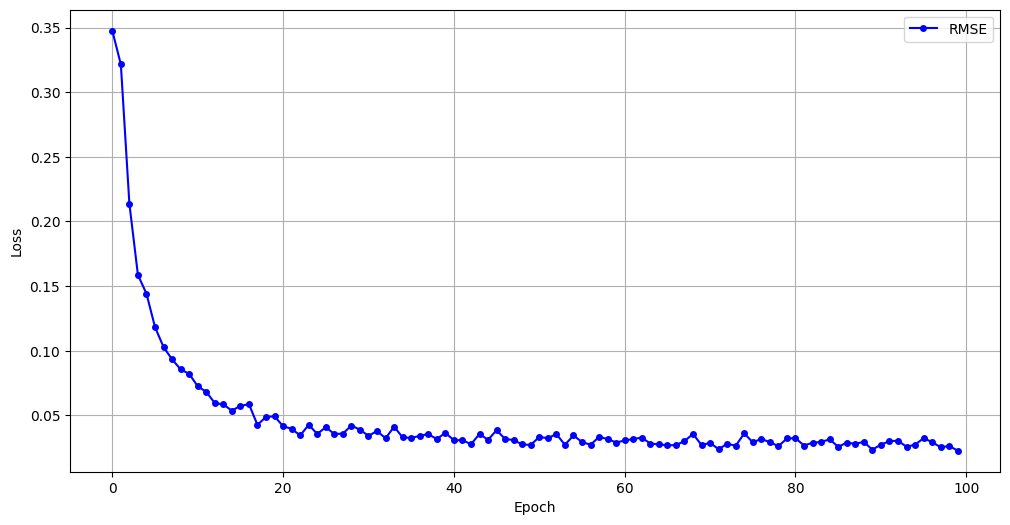

In [39]:
# plot losses
plt.figure(figsize=(12, 6))
plt.plot(losses_train, "-o", color="b",label='RMSE', markersize=4)
#plt.plot(losses_val, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('loss_wind_1h_total.png')
plt.show()



In [31]:
print("average loss: ", np.mean(losses_train))

average loss:  0.04747034436234854


In [32]:
total_solar = np.concatenate((solar_data, solar_data_val), axis=0)
total_solar_X, total_solar_y = move_sliding_window(total_solar, WINDOW_SIZE, range(11), 0, 1)
total_solar_dataset = SolarDataset(total_solar_X, total_solar_y)
dataloader_solar_total = DataLoader(total_solar_dataset, batch_size=32, shuffle=False, drop_last=True)


In [33]:
#Best parameters: {'batch_size': 64, 'iterator_train__shuffle': False, 'max_epochs': 80, 'module__drop_prob': 0.5, 'module__hidden_dim': 64, 'module__n_layers': 1, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.001}
BAT_SIZE = 64
HIDDEN_SIZE = 64
NUM_LAYERS = 1
lr = 0.001
weight_decay = 0.001
N_EPOCHS = 100
DROP_PROB = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
grad_clip_param = 2

solar_1h_model = GRUNet(input_dim=INPUT_SIZE, hidden_dim=HIDDEN_SIZE, output_dim=OUTPUT_SIZE, n_layers=NUM_LAYERS, drop_prob=DROP_PROB).to(device)
optimizer = torch.optim.Adam(solar_1h_model.parameters(), lr=lr, weight_decay=0.0001)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [34]:
solar_1h_model, losses_train_solar_1h = train_model(solar_1h_model, dataloader_solar_total, None, criterion, optimizer, num_epochs=N_EPOCHS, apply_gradient_clipping=True, grad_clip_param=grad_clip_param)

Epoch 0, train loss: 0.24821248836361606
Epoch 1, train loss: 0.22518000595416787
Epoch 2, train loss: 0.2212129259180282
Epoch 3, train loss: 0.2136185914572968
Epoch 4, train loss: 0.17746339653063925
Epoch 5, train loss: 0.1503710694130097
Epoch 6, train loss: 0.13289360837936037
Epoch 7, train loss: 0.1182144397697281
Epoch 8, train loss: 0.11313740681657221
Epoch 9, train loss: 0.09841306884540528
Epoch 10, train loss: 0.08935236069515583
Epoch 11, train loss: 0.09171179154531602
Epoch 12, train loss: 0.08688187958779274
Epoch 13, train loss: 0.08660290378625715
Epoch 14, train loss: 0.08789638084462695
Epoch 15, train loss: 0.08366081368600117
Epoch 16, train loss: 0.07770941124993051
Epoch 17, train loss: 0.07544599559575538
Epoch 18, train loss: 0.07691544306835434
Epoch 19, train loss: 0.07854543676674729
Epoch 20, train loss: 0.07683594227994221
Epoch 21, train loss: 0.07567380179268797
Epoch 22, train loss: 0.08399948789244666
Epoch 23, train loss: 0.07457390363610618
Epoch 

In [35]:
torch.save(solar_1h_model.state_dict(), 'total_solar_1h_model.pth')

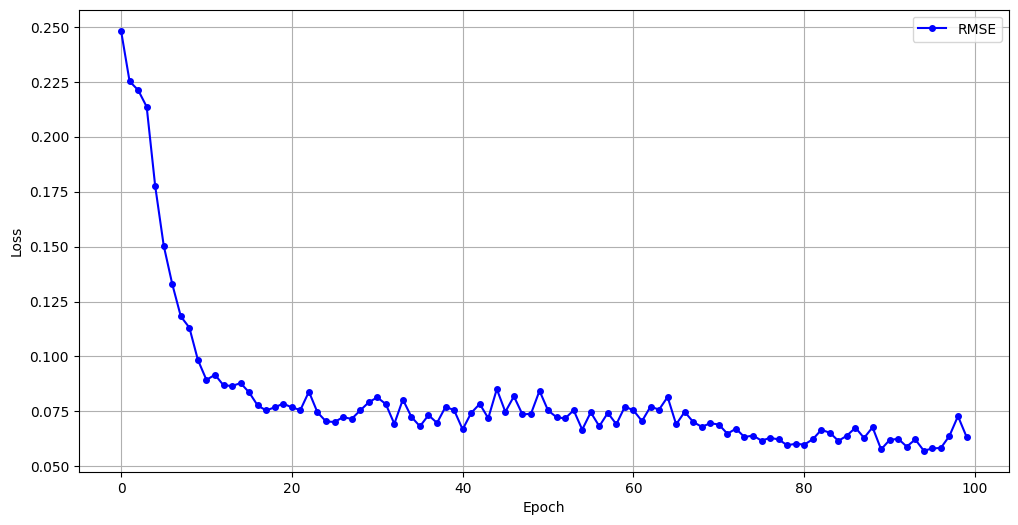

In [38]:
plt.figure(figsize=(12, 6))
plt.plot(losses_train_solar_1h, "-o", color="b",label='RMSE', markersize=4)
#plt.plot(losses_val, label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('loss_solar_1h_total.png')
plt.show()


In [40]:
print('average loss: ', np.mean(losses_train_solar_1h))

average loss:  0.08144445960546631


In [41]:
WINDOW_SIZE = 72
FORECAST_HORIZON = 24

In [42]:
total_solar_24h_X, total_solar_24h_y = move_sliding_window(total_solar, WINDOW_SIZE, range(11), 0, forecast_horizon=FORECAST_HORIZON)
total_solar_24h_dataset = SolarDataset(total_solar_24h_X, total_solar_24h_y)
dataloader_solar_total_24h = DataLoader(total_solar_24h_dataset, batch_size=32, shuffle=False, drop_last=True)


In [56]:
#est parameters: {'batch_size': 64, 'iterator_train__shuffle': False, 'max_epochs': 80, 'module__drop_prob': 0.5, 'module__hidden_dim': 16, 'module__n_layers': 1, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.001}
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_SIZE = 64
NUM_LAYERS = 2
lr = 0.001
weight_decay = 0.001
DROP_PROB = 0.5
grad_clip_param = 2

model_solar_24h = GRUNet(input_dim=INPUT_SIZE, hidden_dim=HIDDEN_SIZE, output_dim=OUTPUT_SIZE, n_layers=NUM_LAYERS, drop_prob=DROP_PROB).to(device)
optimizer = torch.optim.Adam(model_solar_24h.parameters(), lr=lr, weight_decay=weight_decay)

In [57]:
model_solar_24h, losses_train_solar_24h = train_model(model_solar_24h, dataloader_solar_total_24h, None, criterion, optimizer, num_epochs=EPOCHS, apply_gradient_clipping=True, grad_clip_param=grad_clip_param)

Epoch 0, train loss: 0.24011706913137976
Epoch 1, train loss: 0.21333612015150188
Epoch 2, train loss: 0.2106169412578928
Epoch 3, train loss: 0.1943035976476831
Epoch 4, train loss: 0.190762790181516
Epoch 5, train loss: 0.18726234840085873
Epoch 6, train loss: 0.18756285253843982
Epoch 7, train loss: 0.18162082017414152
Epoch 8, train loss: 0.18448352039096846
Epoch 9, train loss: 0.19134440900068797
Epoch 10, train loss: 0.18859932079265332
Epoch 11, train loss: 0.1851982162271482
Epoch 12, train loss: 0.1832260866018333
Epoch 13, train loss: 0.18910597639797444
Epoch 14, train loss: 0.18807264414908176
Epoch 15, train loss: 0.18168677965699898
Epoch 16, train loss: 0.18636164457624793
Epoch 17, train loss: 0.18538428909885576
Epoch 18, train loss: 0.1873690292161863
Epoch 19, train loss: 0.18300575407970154
Epoch 20, train loss: 0.18552852782019402
Epoch 21, train loss: 0.1838360763131044
Epoch 22, train loss: 0.18129278664842194
Epoch 23, train loss: 0.18566950828391918
Epoch 24, 

In [58]:
torch.save(model_solar_24h.state_dict(), 'total_solar_24h_model.pth')

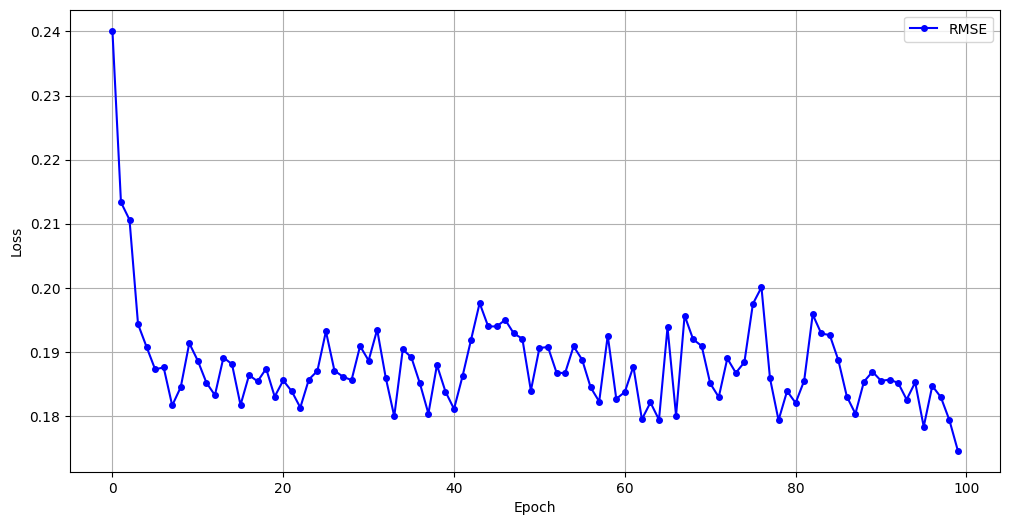

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(losses_train_solar_24h, "-o", color="b",label='RMSE', markersize=4)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('loss_solar_24h_total.png')
plt.show()

In [60]:
print('average loss: ', np.mean(losses_train_solar_24h))

average loss:  0.1879546457092517


In [48]:
total_wind_24h_X, total_wind_24h_y = move_sliding_window(wind_total, WINDOW_SIZE, range(11), 0, forecast_horizon=FORECAST_HORIZON)
total_wind_24h_dataset = SolarDataset(total_wind_24h_X, total_wind_24h_y)
dataloader_wind_total_24h = DataLoader(total_wind_24h_dataset, batch_size=32, shuffle=False, drop_last=True)


In [49]:
#Best parameters: {'batch_size': 64, 'iterator_train__shuffle': False, 'max_epochs': 80, 'module__drop_prob': 0.5, 'module__hidden_dim': 16, 'module__n_layers': 1, 'optimizer__lr': 0.001, 'optimizer__weight_decay': 0.001}
BATCH_SIZE = 64
EPOCHS = 100
HIDDEN_SIZE = 16
NUM_LAYERS = 1
lr = 0.001
weight_decay = 0.001
DROP_PROB = 0.5
grad_clip_param = 2

model_wind_24h = GRUNet(input_dim=INPUT_SIZE, hidden_dim=HIDDEN_SIZE, output_dim=OUTPUT_SIZE, n_layers=NUM_LAYERS, drop_prob=DROP_PROB).to(device)
optimizer = torch.optim.Adam(model_wind_24h.parameters(), lr=lr, weight_decay=weight_decay)

In [50]:
model_wind_24h, losses_train_wind_24h = train_model(model_wind_24h, dataloader_wind_total_24h, None, criterion, optimizer, num_epochs=EPOCHS, apply_gradient_clipping=True, grad_clip_param=grad_clip_param)

Epoch 0, train loss: 0.35873706992920285
Epoch 1, train loss: 0.3407934023037789
Epoch 2, train loss: 0.33241017890573277
Epoch 3, train loss: 0.3266460017070302
Epoch 4, train loss: 0.32047476684526793
Epoch 5, train loss: 0.31628039984830786
Epoch 6, train loss: 0.30553537808240405
Epoch 7, train loss: 0.29835836856793135
Epoch 8, train loss: 0.2857442263727587
Epoch 9, train loss: 0.28239463800985154
Epoch 10, train loss: 0.2798708741358676
Epoch 11, train loss: 0.27772381982250965
Epoch 12, train loss: 0.2788379043568112
Epoch 13, train loss: 0.275041670093861
Epoch 14, train loss: 0.27217229191209297
Epoch 15, train loss: 0.2727489296792664
Epoch 16, train loss: 0.27486742210320864
Epoch 17, train loss: 0.2729248135476868
Epoch 18, train loss: 0.2729443474803507
Epoch 19, train loss: 0.27314759223916374
Epoch 20, train loss: 0.27470377111473143
Epoch 21, train loss: 0.27343361075599115
Epoch 22, train loss: 0.2728561908939128
Epoch 23, train loss: 0.2744709429182158
Epoch 24, trai

In [51]:
torch.save(model_wind_24h.state_dict(), 'total_wind_24h_model.pth')

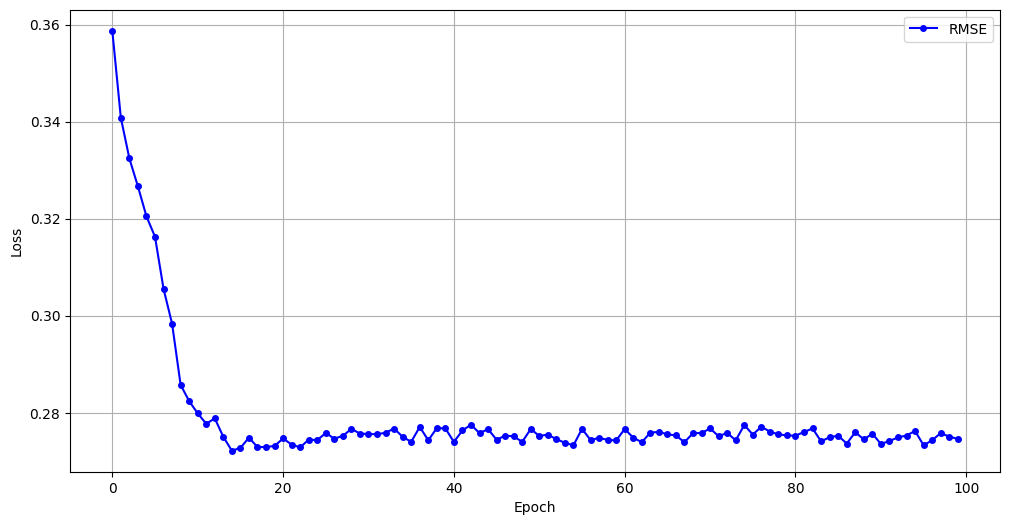

In [52]:
plt.figure(figsize=(12, 6))
plt.plot(losses_train_wind_24h, "-o", color="b",label='RMSE', markersize=4)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('loss_wind_24h_total.png')
plt.show()

In [53]:

print('average loss: ', np.mean(losses_train_wind_24h))

average loss:  0.2793858460134739
